In [40]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.impute import SimpleImputer, KNNImputer

import warnings 
warnings.filterwarnings('ignore')

# 0. Data Pre-Processing and EDA

### COVID-19 Dataset

**Problem Setting:**
At the peak of the COVID-19 pandemic, hospital authorities had to make a call about who to admit and who to send home given the limited available resources. Our problem is to have a classifier that suggests whether a patient should be immediately admitted to the hospital or sent home.

**Goal:**
The goal of this project is to predict the urgency with which a COVID-19 patient will need to be admitted to the hospital from the time of onset of symptoms. The dataset contains some COVID-19 symptoms and demographic information. Notably, this dataset was collected in the peak of a COVID-19 wave and hence may have some errors and missing data.

Primary predictors:
- age 
- sex
- cough, fever, chills, sore_throat, headache, fatigue. For each: 1 if have symptom, 0 if no symptom 

Response variable:  Urgency of admission where 
- 1 => High Urgency which means the patient was admitted within 1 day from the onset of symptoms
- 0 => No Urgency - everyone else 

In [41]:
from striprtf.striprtf import rtf_to_text
from io import StringIO

file_path = 'covid.csv.rtf' # file path of .rtf raw data

# Step 1: Extract text from the RTF file

with open(file_path, 'r') as file:
    rtf_content = file.read()
text_content = rtf_to_text(rtf_content)

# Step 2: Convert the extracted text to a DataFrame
# Since the data is structured like a CSV, we use StringIO to treat the string as a file

data_io = StringIO(text_content)
df = pd.read_csv(data_io)

df.head(5)

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,Urgency
0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,59.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


### Imputing Missing Data

In [42]:
# Check if there are any missing or Null values

df.isna().sum()

X_raw = df.iloc[:,0:-1]
y_raw = df.iloc[:,-1]

In [43]:
# Find the number of rows with missing values

num_null = df.isna().any(axis=1).sum()
print("Number of rows with null values:", num_null)

Number of rows with null values: 37


In [44]:
# kNN impute the missing data using a k value of 5

X_imputed_array = KNNImputer(n_neighbors=5).fit_transform(X_raw)

In [45]:
# Replace original dataframe with the imputed data

X_imputed = pd.DataFrame(X_imputed_array, columns=X_raw.columns)
df.iloc[:, 0:-1] = X_imputed.round(0)

In [46]:
# Double check whether missing data has been succesfully replaced

df.isna().sum()

age            0
sex            0
cough          0
fever          0
chills         0
sore_throat    0
headache       0
fatigue        0
Urgency        0
dtype: int64

# 1. Explorative Data Analysis (EDA)

In [47]:
urgent_age = df[df['Urgency'] == 1]
urgent_age

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,Urgency
6,38.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
7,45.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
10,42.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
12,65.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13,44.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...
996,72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
997,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
998,43.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
999,39.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1


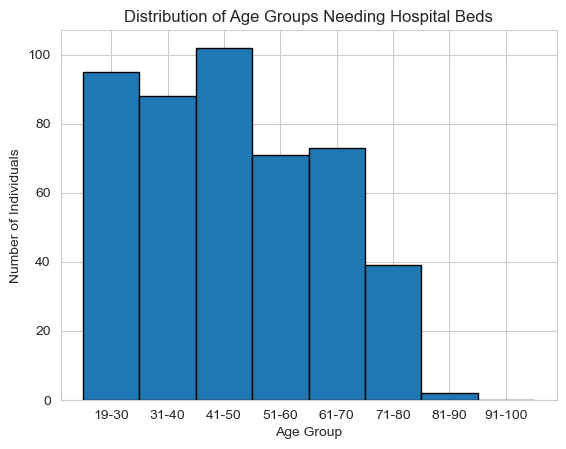

In [48]:
# Assuming 'Age' is a continuous variable

plt.hist(urgent_age["age"], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100], edgecolor='black')
plt.xlabel('Age Group')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Age Groups Needing Hospital Beds')
plt.xticks([25, 35, 45, 55, 65, 75, 85, 95], ['19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])
plt.savefig("assets/distribution_age_groups")
plt.show()

 The age group of 41-50 has the most urgent need for a hosphital bed

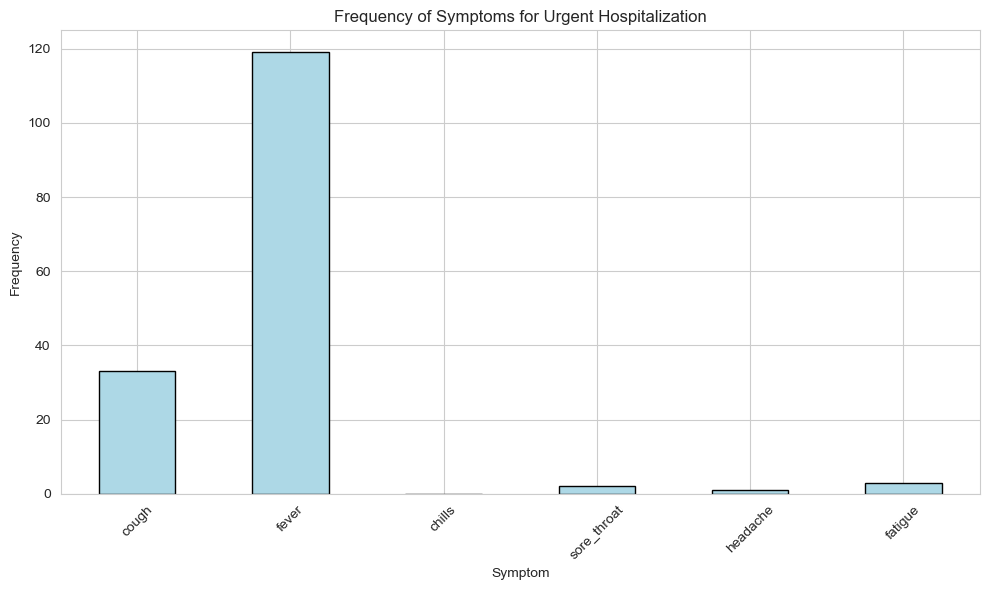

In [49]:
# plotting most common symptons for urgent need for hospitalization

common_symp = urgent_age.iloc[:,2:-1].sum()

common_symp.plot(kind='bar', figsize=(10, 6), color='lightblue', edgecolor='black')
plt.title('Frequency of Symptoms for Urgent Hospitalization')
plt.xlabel('Symptom')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig("assets/frequency_symptoms_urgency")
plt.show()

Fever is the most common symptom for urgent hospitalization, followed by cough.

### Counts of Cough by Urgency  

In [50]:
# urgency - cough data
urgent_cough = common_symp["cough"]

# no urgency - cough data

no_urgency = df[df['Urgency'] == 0]
no_urgency = no_urgency.iloc[:,2:-1].sum()

no_urgent_cough =no_urgency["cough"]

In [51]:
# Data prep for plotting

labels = ['Cough']
urgent_counts = [urgent_cough]
non_urgent_counts = [no_urgent_cough]

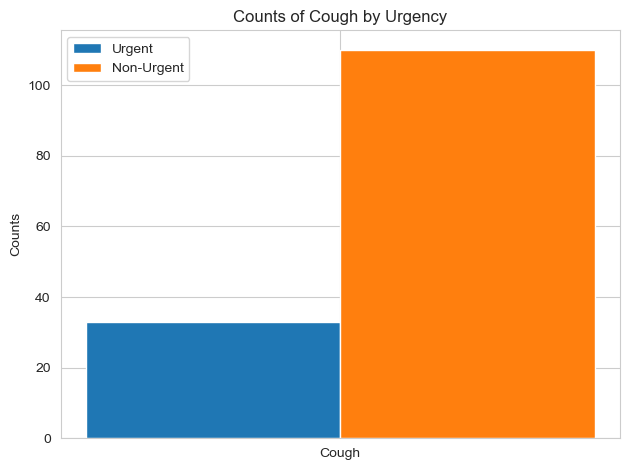

In [52]:
# Plotting counts of cough by urgency

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, urgent_counts, width, label='Urgent')
rects2 = ax.bar(x + width/2, non_urgent_counts, width, label='Non-Urgent')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Counts')
ax.set_title('Counts of Cough by Urgency')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig("counts_of_cough_by_urgency")

plt.show()

Patients with no urgent need of hospitalization have cough as more common symptom than patients with no urgency.

# 2. Train / Test Split

In [53]:
# Split the data into training and test sets with 30% test size and random sate of 60

df_train, df_test = train_test_split(df, test_size=0.3, random_state=60)

In [54]:
print(df_train.shape, df_test.shape)

(700, 9) (301, 9)


In [55]:
# Save the train and test data into a csv called "covid_train.csv"

df_train.to_csv('covid_train.csv', index=False)
df_test.to_csv('covid_test.csv', index=False)

# 3. Prediction

In [56]:
X_train = df_train.iloc[:, 0:-1]
y_train = df_train.iloc[:, -1]

In [57]:
X_test = df_test.iloc[:, 0:-1]
y_test = df_test.iloc[:, -1]

### Classification Model (KNN)

I use a K-neighbour classifier model with k = 10 to fit and predict the urgency of covid patients.

In [58]:
model = KNeighborsClassifier(n_neighbors = 10)

model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

### Prediction & Model Accuracy

In [59]:
y_pred = model.predict(X_test)

In [60]:
from sklearn.metrics import accuracy_score

model_accuracy = model.score(X_test, y_test)
print(f"Model Accuracy is {model_accuracy}")

Model Accuracy is 0.6910299003322259


Model Accuracy is 0.6910299003322259

# 4. Evaluating Predictions with Other Metrics

Compute metrics other than accuracy to judge the efficacy of our model's predictions. 

*learning*: The accuracy score for both the kNN and Logistic Regression models are the same and so accuracy is not always the best metric for classification, especially when there is class imbalance.

### Fit Other Models:

- Classification model using KNN, with k = 7
- Logistic model using regression, with c = 0.01, where c = inverse of regularization strength

A lower value of C lead to increased regularization. In the context of LogisticRegression, regularization can be L1 (Lasso), L2 (Ridge), or both (Elastic Net), depending on the penalty parameter.

**Effect on the Model:**
Higher C Values: A higher C value leads to less regularization, allowing the model to be more complex. This can be useful if the model is underfitting, i.e., not capturing the underlying trend in the data.
Lower C Values: A lower C encourages more regularization, which constrains the model, potentially reducing overfitting but risking underfitting if the regularization is too strong

Selecting the right C value is crucial for model performance. A common practice is to use cross-validation (e.g., GridSearchCV in scikit-learn) to find the C value that yields the best model performance on a validation set.

### KNN-Model (k= 7):

In [61]:
knn_model = KNeighborsClassifier(n_neighbors =7)

knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

### Logistic Model:

In [62]:
log_model = LogisticRegression(max_iter = 10000, C = 0.1 )

log_model.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=10000)

### Prediction:

In [63]:
y_pred_knn = knn_model.predict(X_test)
y_pred_log = log_model.predict(X_test)

## Evaluation of the New Models:

Creating dictionary (metric_scores) w/ keys 'Accuracy', 'Recall', 'Specificity', 'Precision', and 'F1-score'. All scores are made on the test data.

In [64]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Prediction
predictions = {
    "knn_10": y_pred,
    'knn_7': y_pred_knn,
    "log": y_pred_log
}

# Initialize the metric_scores dictionary
metric_scores = {
    "Accuracy": [],
    "Recall": [],
    "Specificity": [],
    "Precision": [],
    "F1-score": []
}

In [65]:
# Loop through each model's predictions to compute metrics
for model, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Append the computed metrics to the corresponding lists in metric_scores dictionary
    metric_scores["Accuracy"].append(accuracy)
    metric_scores["Recall"].append(recall)
    metric_scores["Specificity"].append(specificity)
    metric_scores["Precision"].append(precision)
    metric_scores["F1-score"].append(f1)

print(metric_scores)

{'Accuracy': [0.6910299003322259, 0.6810631229235881, 0.6079734219269103], 'Recall': [0.6524822695035462, 0.7375886524822695, 0.7163120567375887], 'Specificity': [0.725, 0.63125, 0.5125], 'Precision': [0.6764705882352942, 0.6380368098159509, 0.5642458100558659], 'F1-score': [0.6642599277978339, 0.6842105263157894, 0.63125]}


{'Accuracy': [0.6079734219269103, 0.6810631229235881, 0.6079734219269103], 'Recall': [0.7163120567375887, 0.7375886524822695, 0.7163120567375887], 'Specificity': [0.5125, 0.63125, 0.5125], 'Precision': [0.5642458100558659, 0.6380368098159509, 0.5642458100558659], 'F1-score': [0.63125, 0.6842105263157894, 0.63125]}


### Plotting Evaluation Scores

In [66]:
metric_scores_df = pd.DataFrame(metric_scores, index=['KNN_10', 'KNN_7', 'Logistic Regression']).T
metric_scores_df = metric_scores_df.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')
metric_scores_df.rename(columns={'index': 'Metric'}, inplace=True)

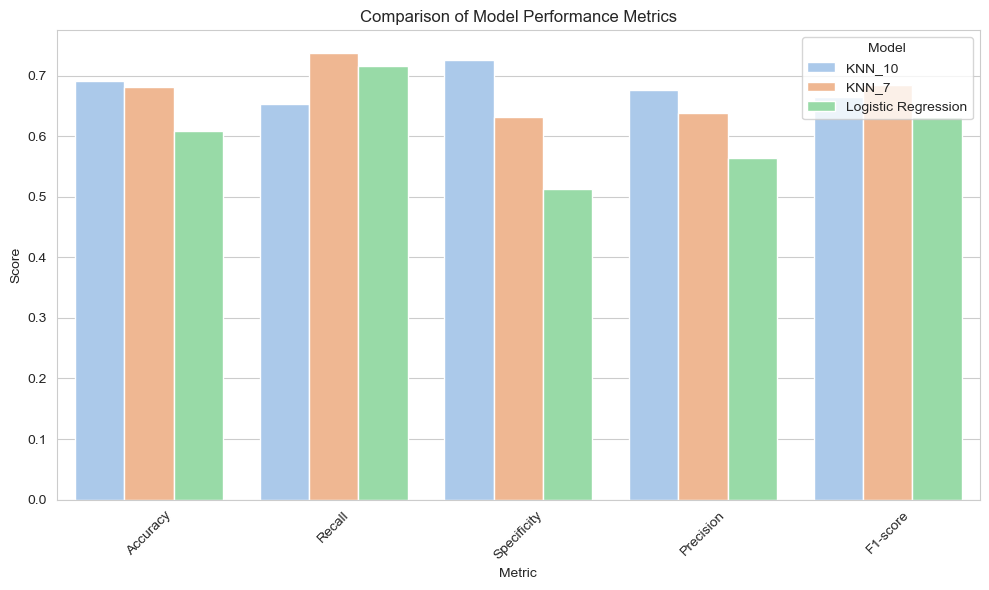

In [67]:
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Metric', y='Score', hue='Model', data=metric_scores_df, palette='pastel')

plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.legend(title='Model', loc='upper right')

plt.tight_layout()
plt.savefig("assets/evaluation_metrics_comparison")
plt.show()

# 5. Selection of Best Metrics

It is not clear how to choose which metric(s) from the previous exercise to use to pick the best model. For this reason, I calculate the AUC scores and plot the ROC curves for both the kNN and the logistic regression models and use that information to decide which model is ideal for each of the scenarios.

### Predict Probabilities

Predict probabilities for the positive class on the test data.

`predict_proba` method returns probabilities for all classes. We only want the probabilities for the positive class (i.e., $y = 1$). 

In [68]:
y_pred_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logreg = log_model.predict_proba(X_test)[:,1]

# ROC Curve

The Bayes threshold of a binary classifier is the value for which all predicted probabilities greater than or equal to that value are labeled as the positive class. For example, a classifier with a Bayes threshold of 0.6 will classify all observations with a predicted probability, $p \geq 0.6$, as the positive class (1) and all observations with a predicted probability, $p < 0.6$, as the negative class (0).

The ROC curve shows us a model's false positive  and true positive rates across different settings of the Bayes Threshold. 

Recall that:
$$\text{False Positive Rate} = \frac{FP}{TN + FP}$$
$$\text{True Positive Rate} = \frac{TP}{TP + FN}$$

We will compute the false positve rate (FPR) and true positive rate (TPR) for a range of thresholds and use these values to plot ROC curves for both the kNN and the logistic regression models.

# Thresholds

First, we need to generate a range of thresholds to use for turning our models' probability predictions into class labels. One naive approach might be to simply create a list of evenly spaced values between 0 and 1 and use these for both models. But this is not ideal. Consider the fact that some threshold changes will not actually affect the model's classification labels.

This approach involves to evaluate just those thresholds that result in different class label predictions. And these precise thresholds will depend on our model.

The `get_thresholds` function takes a model's predicted probabilities on the test set and returns an array of thresholds.

In [69]:
def get_thresholds(y_pred_proba):
    # We only need to consider unique predicted probabilities
    unique_probas = np.unique(y_pred_proba)
    # Sort unique probabilities in descending order
    unique_probas_sorted = np.sort(unique_probas)[::-1]
   
    # We'll also add some additional thresholds to our set
    # This ensures our ROC curves reach the corners of the plot, (0,0) and (1,1)
    
    # A value greater than 1 is required if we want the ROC curve
    # to reach the lower left corner (0 fpr, 0 tpr) considering
    # one of our models produces probability predictions of 1
    thresholds = np.insert(unique_probas_sorted, 0, 1.1)
    # Append 0 to the end of the thresholds
    thresholds = np.append(thresholds, 0)
    return thresholds

In [70]:
knn_thresholds = get_thresholds(y_pred_knn)

logreg_thresholds = get_thresholds(y_pred_logreg)

### FPR

In [71]:
# Use the true $y$ class label and the predicted probabilities to determine the fpr and tpr on test data for a specific threshold.

def get_fpr(y_true, y_pred_proba, threshold):
    
    y_pred_label = (y_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label).ravel()

    fpr = fp / (fp + tn)

    return fpr

In [72]:
knn_fpr = [get_fpr(y_test, y_pred_knn, threshold) for threshold in knn_thresholds]

logreg_fpr = [get_fpr(y_test, y_pred_logreg, threshold) for threshold in logreg_thresholds]

### TPR

In [73]:
def get_tpr(y_true, y_pred_proba, threshold):

    y_pred_label = (y_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label).ravel()

    tpr = tp / (tp + fn)

    return tpr

In [74]:
knn_tpr = [get_tpr(y_test, y_pred_knn, threshold) for threshold in knn_thresholds]

logreg_tpr = [get_tpr(y_test, y_pred_logreg, threshold) for threshold in logreg_thresholds]

### AUC (Area Under the Curve)

The AUC gives us an idea as to how well our model does across all thresholds.

For our final calculations, I use each model's predicted probabilities to compute its test AUC with the help of SKLearn's `roc_auc_score` function.

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
# ROC AUC score of the knn model
knn_auc = roc_auc_score(y_test, y_pred_knn)

# ROC AUC score of the Logistic model
logreg_auc = roc_auc_score(y_test, y_pred_logreg)

print(knn_auc, logreg_auc)

0.7259751773049644 0.661613475177305


### Plotting ROC

ROC curves are a very powerful tool as a statistical performance measure in detection/classification theory. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

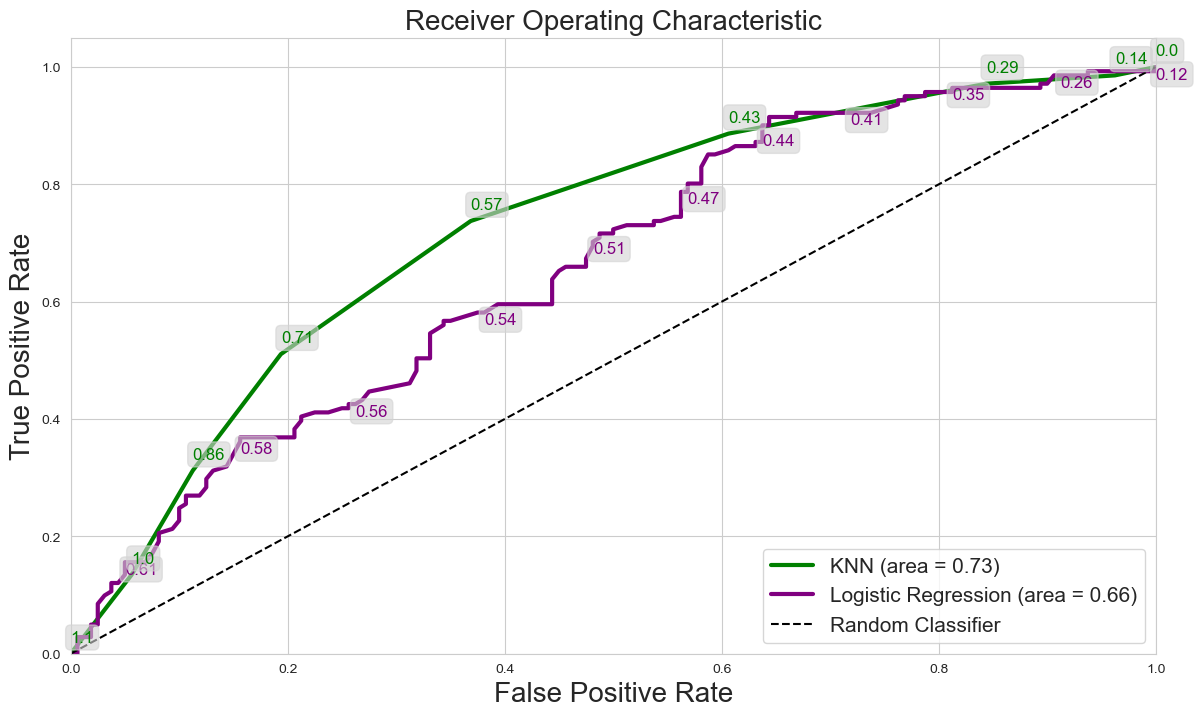

In [77]:
# Area under curve - Logistic Regression & kNN
fig, ax = plt.subplots(figsize = (14,8))

# Plot KNN Regression ROC Curve
ax.plot(knn_fpr,
        knn_tpr,
        label=f'KNN (area = {knn_auc:.2f})',
        color='g',
        lw=3)

# Plot Logistic Regression ROC Curve
ax.plot(logreg_fpr,
        logreg_tpr,
        label=f'Logistic Regression (area = {logreg_auc:.2f})',
        color = 'purple',
        lw=3)

# Threshold annotations
label_kwargs = {}
label_kwargs['bbox'] = dict(
    boxstyle='round, pad=0.3', color='lightgray', alpha=0.6
)
eps = 0.02 # offset
for i in range(0, len(logreg_fpr),15):
    threshold = str(np.round(logreg_thresholds[i], 2))
    ax.annotate(threshold, (logreg_fpr[i], logreg_tpr[i]-eps), fontsize=12, color='purple', **label_kwargs)

for i in range(0, len(knn_fpr)-1):
    threshold = str(np.round(knn_thresholds[i], 2))
    ax.annotate(threshold, (knn_fpr[i], knn_tpr[i]+eps), fontsize=12, color='green', **label_kwargs)

# Plot diagonal line representing a random classifier
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

ax.set_xlim([0.0, 1.0]);
ax.set_ylim([0.0, 1.05]);
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('Receiver Operating Characteristic', fontsize=20)
ax.legend(loc="lower right", fontsize=15)

plt.savefig("assets/roc")
plt.show()

# 6. Covid-19 Scenario Analysis

When interpreting the ROC curve and selecting a threshold, it's crucial to consider the specific context of its application. Different applications may tolerate false positives more than false negatives, or vice versa. Therefore, while the statistical methods provide a starting point, the final decision should align with the application's specific needs and the costs associated with different types of errors.

Therefore we use an example of various countries and their policy measures during the Covid-19 pandemic.

### Scenario 1 - Brazil
In Brazil, the new COVID variant is contagious and infects many citizens. Brazilian officials, however, dictate that hospitals do not classify many people at 'high' risk to avoid bad press and subsequent political global backlash. To model this scenario well, the best classifier with the following restriction is needed: *TPR + FPR <= 0.5*

### Scenario 2 - Germany
German officials want the fatality ratio to be as low as possible. Thus, it is imperative to find cases that need urgent attention and give them the best chance of survival. Therefore, the best classifier with the following restriction is needed: *0.8 <= TPR <= 0.9*

### Scenario 3 - India
India has only 1 million beds left and there are already 2 million people suspected of having the disease. Officials need to work out a strategy to find the people who are in the most need of urgent care. This scenario leads to the following restriction: *TPR + FPR <= 1*


**Important:**
*These are examples, not the actual way that each country handled the pandemic. While the strategies I described are simplified versions of each country's approach, we do not know how they actually decided on their COVID-19 responses.*

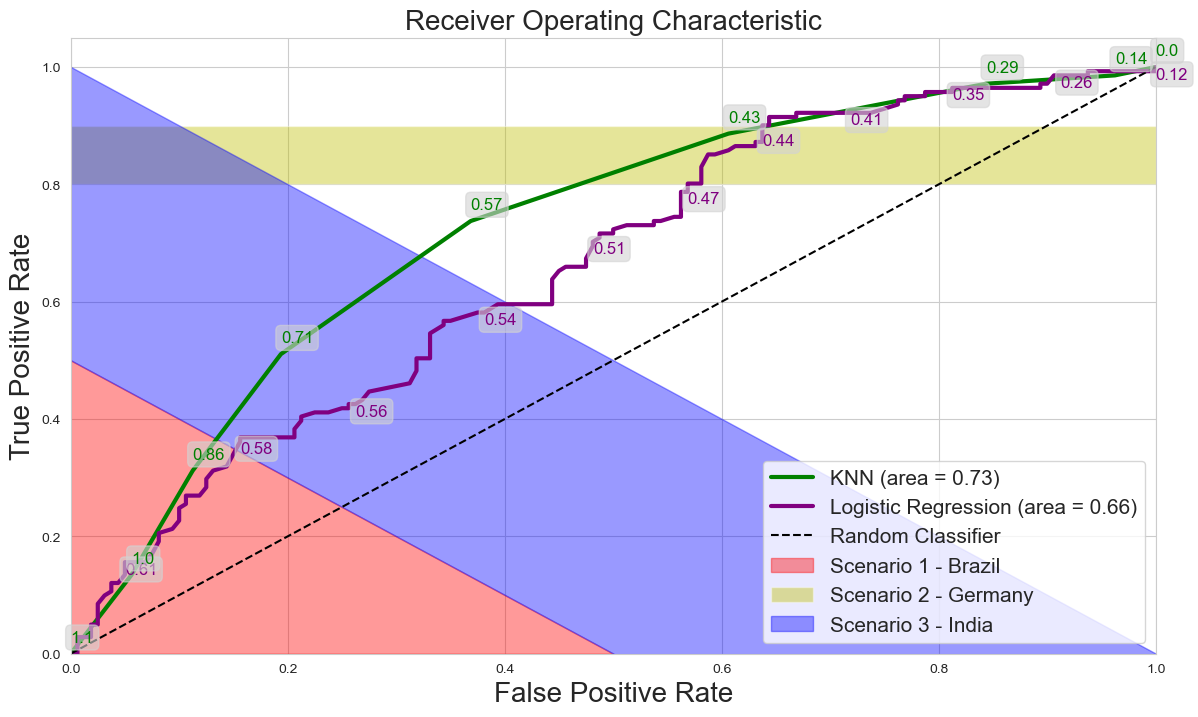

In [78]:
# Area under curve - Logistic Regression & kNN
fig, ax = plt.subplots(figsize = (14,8))

# Plot KNN Regression ROC Curve
ax.plot(knn_fpr,
        knn_tpr,
        label=f'KNN (area = {knn_auc:.2f})',
        color='g',
        lw=3)

# Plot Logistic Regression ROC Curve
ax.plot(logreg_fpr,
        logreg_tpr,
        label=f'Logistic Regression (area = {logreg_auc:.2f})',
        color = 'purple',
        lw=3)

# Threshold annotations
label_kwargs = {}
label_kwargs['bbox'] = dict(
    boxstyle='round, pad=0.3', color='lightgray', alpha=0.6
)
eps = 0.02 # offset
for i in range(0, len(logreg_fpr),15):
    threshold = str(np.round(logreg_thresholds[i], 2))
    ax.annotate(threshold, (logreg_fpr[i], logreg_tpr[i]-eps), fontsize=12, color='purple', **label_kwargs)

for i in range(0, len(knn_fpr)-1):
    threshold = str(np.round(knn_thresholds[i], 2))
    ax.annotate(threshold, (knn_fpr[i], knn_tpr[i]+eps), fontsize=12, color='green', **label_kwargs)

# Plot diagonal line representing a random classifier
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Scenario 1 - Brazil
ax.fill_between([0,0.5],[0.5,0], color = 'red', alpha = 0.4, label='Scenario 1 - Brazil');

# Scenario 2 - Germany
ax.axhspan(0.8, 0.9, facecolor='y', alpha=0.4, label = 'Scenario 2 - Germany');

# Scenario 3 - India
ax.fill_between([0,1],[1,0],[0.5,-0.5], alpha = 0.4, color = 'blue', label = 'Scenario 3 - India');

ax.set_xlim([0.0, 1.0]);
ax.set_ylim([0.0, 1.05]);
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('Receiver Operating Characteristic', fontsize=20)
ax.legend(loc="lower right", fontsize=15)

plt.savefig("assets/roc_scenarios")
plt.show()

### Choice of Classifier

- BRAZIL : Logistic regression with a high threshold
- GERMANY : Logistic regression with a low threshold
- INDIA : kNN classifier with a moderate threshold